In [1]:
import os
import sys
# import scipy.io
# import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint

2023-08-30 13:36:17.341914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 13:36:17.995389: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False, input_shape=(img_size, img_size, 3), weights='./datasets/w4A_datasets/pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

2023-08-30 13:36:20.168694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-30 13:36:20.188649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-30 13:36:20.188796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

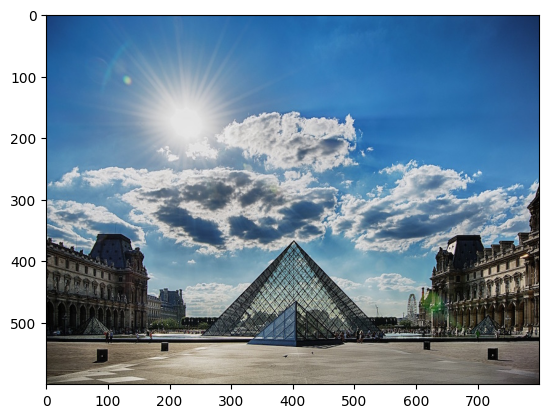

In [3]:
content_image = plt.imread("./datasets/w4A_datasets/images/louvre.jpg")
plt.imshow(content_image)
plt.show()

In [4]:
# UNQ_C1
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    ### START CODE HERE
    
    # Retrieve dimensions from a_G (≈1 line)
    _, n_H, n_W, n_C = list(a_G.shape)
    
    # Reshape 'a_C' and 'a_G' (≈2 lines)
    # DO NOT reshape 'content_output' or 'generated_output'
    a_C_unrolled = tf.reshape(a_C, [n_H*n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, [n_H*n_W, n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = 1/4/n_H/n_C/n_W * tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled), axis = None)
    
    ### END CODE HERE
    
    return J_content

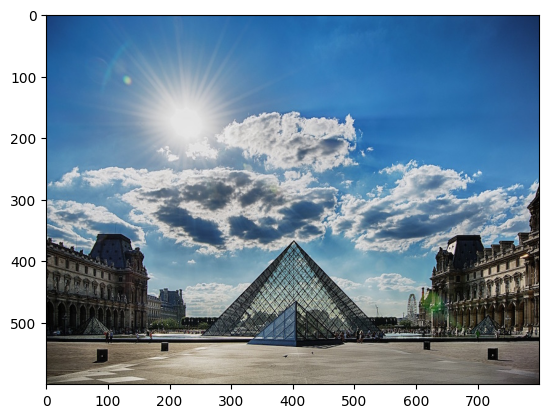

In [5]:
# Getting the style image
example = plt.imread("./datasets/w4A_datasets/images/louvre.jpg")
plt.imshow(example)
plt.show()

In [6]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    ### START CODE HERE
    
    #(≈1 line)
    GA = tf.matmul(A,tf.transpose(A,[1,0]))
    
    ### END CODE HERE

    return GA

In [7]:
# UNQ_C3
# GRADED FUNCTION: compute_layer_style_cost
import copy
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    ### START CODE HERE
    
    # Retrieve dimensions from a_G (≈1 line)
    _, n_H, n_W, n_C = list(a_G.shape)
    
    # Reshape the tensors from (1, n_H, n_W, n_C) to (n_C, n_H * n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, [-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [-1, n_C]))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = (1/(2.*n_C*n_H*n_W)/(2.*n_C*n_H*n_W))*tf.reduce_sum(tf.square(GS - GG), axis = None)
    
    ### END CODE HERE
    return J_style_layer

In [8]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [9]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

In [10]:
# UNQ_C4
# GRADED FUNCTION: total_cost
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    ### START CODE HERE
    
    #(≈1 line)
    J = alpha * J_content + beta * J_style
    
    ### START CODE HERE

    return J

(1, 400, 400, 3)


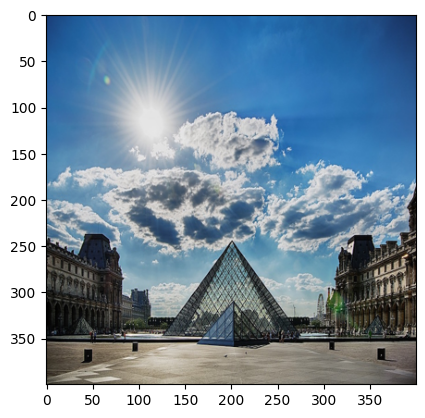

In [11]:
content_image = np.array(Image.open("./datasets/w4A_datasets/images/louvre.jpg").resize((img_size, img_size)))
content_image = tf.constant(content_image.reshape((1,)+content_image.shape))

style_image = np.array(Image.open("./datasets/w4A_datasets/images/monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(style_image.reshape((1,)+style_image.shape))

print(content_image.shape)

imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


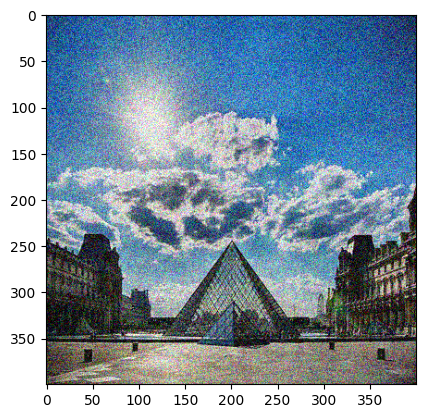

In [12]:
# Initialize the generated image
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(generated_image.shape, -.25, .25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, 0, 1)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()
generated_image = tf.Variable(generated_image)

In [13]:
def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    model = tf.keras.models.Model([vgg.input], outputs)
    return model

content_layer = [("block5_conv4", 1)]
vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

2023-08-30 13:36:21.554008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-08-30 13:36:21.628437: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-30 13:36:21.628994: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-30 13:36:21.629008: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-08-30 13:36:21.629600: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-30 13:36:21.629683: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

In [14]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [15]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [16]:
# UNQ_C5
# GRADED FUNCTION: train_step

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        
        ### START CODE HERE
        
        # Compute a_G as the vgg_model_outputs for the current generated image
        #(1 line)
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        #(1 line)
        J_style = compute_style_cost(a_S, a_G)

        #(2 lines)
        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style)
        
        ### END CODE HERE
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

In [17]:
# # Show the generated image at some epochs
# # Uncomment to reset the style transfer process. You will need to compile the train_step function again 
# epochs = 2501
# for i in range(epochs):
#     train_step(generated_image)
#     if i % 250 == 0:
#         print(f"Epoch {i} ")
#     if i % 250 == 0:
#         image = tensor_to_image(generated_image)
#         imshow(image)
#         image.save(f"output/image_{i}.jpg")
#         plt.show() 

In [ ]:
# The training process
fig = plt.figure(figsize=(10,40))
epoches = 2999
j = 1
for epoch in range(epoches):
    train_step(generated_image)
    if epoch%250==0:
        print(f"epoch {epoch}")
        plt.subplot(7,2,j)
        plt.title(f"epoch {epoch}")
        plt.imshow(generated_image[0])
        j += 1
        train_step(generated_image)
    else:
        None
plt.show()